In [1]:
import svgling, svgling.html, svgling.figure
from svgling.figure import SideBySide, RowByRow, Caption
# two sample trees
t0 = ("S", ("NP", "D", "N"), ("VP", "V", ("NP", "D", "A", "N")))
t1 = ("S", ("NP", ("D", "the"), ("N", "rhinoceros")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("A", "gray"), ("N", "elephant"))))
demo_trees = [t0, t1]

# Guide to the `svgling` package

The `svgling` package is a python tree-drawing package, aimed at linguists who want to draw constituent trees. It is tailored specifically towards rendering trees in Jupyter, but could be used for programmatically generating SVG tree diagrams in general.

* [1. Interface overview](#1.-Interface-overview)
   - [SVG formatting](#SVG-formatting)
   - [Nodes and constituents](#Nodes-and-constituents)
   - [NLTK integration](#NLTK-integration)
* [2. Layout and display options](#2.-Layout-and-display-options)
   - [Layout overview](#Layout-overview)
   - [Debug mode](#Debug-mode)
   - [Overall layout options](#Overall-layout-options)
   - [Line and node positioning options](#Line-and-node-positioning-options)
   - [Text options](#Text-options)
* [3. Tree annotations](#3.-Tree-annotations)
   - [Annotating constituents](#Annotating-constituents)
   - [Movement arrows](#Movement-arrows)
* [4. Complex figures](#4.-Complex-figures)
* [5. Hybrid HTML/SVG diagrams](#5.-Hybrid-HTML%2FSVG-diagrams)
* [6. Compatibility and conversion](#6.-Compatibility-and-conversion)

## 1. Interface overview

The main interface to `svgling` is `svgling.draw_tree`. This function takes a tree description, and named arguments specifying options. The valid options are described below, and options parameters are used to construct a `svgling.core.TreeOptions` object; such an object can be passed directly and passed via a named argument `options`. The default options can be accessed via `svgling.core.TreeOptions()`.

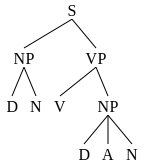

In [2]:
svgling.draw_tree(t0)

The tree description can be in one of two forms: an indexable object (e.g. list, tuple) consisting of a head at index 0 and a possibly empty sequence of subtrees at indices $1..n$, or an object implementing the `nltk.Tree` api, which stores the head label in the function `.label()` and the daughter subtrees as indices on the object. See `t0` and `t1` above for examples of the indexable format, but this is pretty standard notation going back to lisp.

The package integrates with `nltk` if available, and by default, `nltk` will attempt to use `svgling` to render tree structures when displayed directly in the notebook. Rendering options for trees displayed this way can be adjusted by setting values on `svgling.core.default_options`, which is a `svgling.core.TreeOptions` instance. `nltk.tree.Tree` objects can also be passed directly to `draw_tree`.

### SVG formatting

Many options through this document interact with SVG formatting, via arguments pass to the `svgwrite` API. I won't specify the details of this here, see the `svgwrite` docs for details. Generally, `svgwrite` formatting parameters are validated and passed transparently through to svg itself with the python `_` character turned into `-`, so for details of how svgwrite parameters are interpreted, also see the SVG specification (and whatever viewer-specific documentation there is - not all SVG renderers are alike). I have generally not passed through all parameters, but rather chosen a few that I think are the most useful. Two key parameters that show up repeatedly for lines are `stroke` (which gets filled in with a color or `none`) and `stroke_width` (which gets filled in with a measurement, usually in user units for `svgling` trees).

**Units**: SVG uses CSS-style units, which can be a little confusing. Here's a quick reference primer on the ones that will come up in this manual.
* `user units`: the default internal unit of an SVG diagram. For svgling trees, at their default sizing, `1` is equivalent to `1px`. However, trees may be resized depending on the display context.
* `px`: stands for "pixel", but does not necessarily correspond literally to a pixel in CSS; the interpretation is more abstract. The increment `1px` corresponds to an optical reference unit that is the smallest object likely to be visible on a screen. Some but not all displays can render objects that are less than `1px`.
* `em`: the height of one line of text, at the current font size, from baseline to baseline.
* `%`: percentage of the immediately containing SVG box.
* `pt`: a unit inherited from print typography, but again in CSS this is interpreted kind of abstractly and won't really correspond to any reliable physical distance (what you might expect from the history). Not recommended for screen-oriented rendering. For css and svg, `1pt = 0.75px` (so `12pt = 16px`, for the most useful special case).

### Nodes and constituents

**Nodes**: A tree node is (for now) just a string. This string may span multiple lines, which are separated by `\n`. For example: `"N\ncat"` gives a two-line node with `N` as the first like and `cat` as the second. Within a node, multiple lines are anchored at the middle (leading to centering). A label consisting of the empty string `""` is considered empty, and will not render at all -- the lines will be joined in the middle of the row height. If you want a blank label, any sequence of whitespace will work, e.g. `" "`.

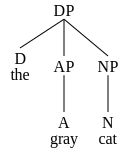

In [3]:
svgling.draw_tree("DP", "D\nthe", ("AP", "A\ngray"), ("NP", "N\ncat"))

**Selecting nodes and constituents**: For various purposes discussed throughout this manual, you can select particular parts of a tree (usually nodes or constituents) for formatting. To do this, you use what is sometimes called a **tree path**. These are sequences of indices that traverse the tree from the root node by choosing a daughter in left-to-right order. Indices begin at 0.

So for example, the path `(0,1,1)` gives the second daughter of the second daughter of the first daughter of the root node. The empty path `()` gives the subtree headed at the root. As this example illustrates, a path needn't be complete, and for annotation purposes will typically be interpreted as selecting an entire constituent, though for some purposes it may select a node. As a reminder, a length 1 path written as a tuple will require a comma so that python can disambiguate it from just a regular number in parenthesis, e.g. `(0,)`. A path that selects a daughter node whose index is greater than the number of daughters at that point in the tree is invalid. Using negative indices is possible, and these will be interpreted like negative indices in python: e.g. `-1` selects the rightmost node, etc.

The following diagram illustrates some example valid tree paths as python tuples.

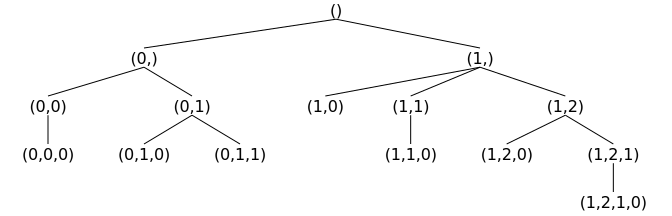

In [4]:
svgling.draw_tree(("()", ("(0,)", ("(0,0)", "(0,0,0)"), ("(0,1)", "(0,1,0)", "(0,1,1)")),
                         ("(1,)", "(1,0)", ("(1,1)", "(1,1,0)"), ("(1,2)", "(1,2,0)", ("(1,2,1)", "(1,2,1,0)")))),
                 font_style=svgling.core.MONO, average_glyph_width=1.5)

Relative to the above tree, the paths `(2,)` and `(1,0,0)` would (for example) be invalid. The paths `(-1,-1,-1)` and `(-1,2,-2)` (for example) would select the subtree identified by `(1,2,1)` and `(1,2,0)` respectively.

## NLTK integration

The `svgling.draw_tree` function can handle `nltk.Tree` objects (or any object using the same API) transparently. By default, the `nltk` package on recent versions also implements `_repr_svg_()` using `svgling`, and so nltk Trees will render using this package.

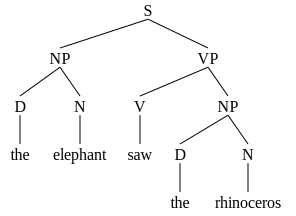

In [5]:
import nltk
t3 = nltk.Tree.fromstring("(S (NP (D the) (N elephant)) (VP (V saw) (NP (D the) (N rhinoceros))))")
t3

You can also supply `Tree` objects directly to `draw_tree`, which allows you to style them in more complex ways:

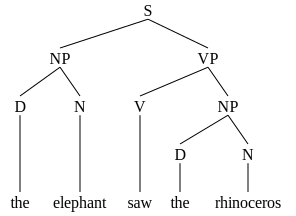

In [6]:
svgling.draw_tree(t3, leaf_nodes_align=True)

n.b. I'm not aware of any way to get `fromstring` to allow multi-line leafs, so if you want to do this in `nltk`, you'll need to construct the tree more directly. (You can supply options for trees drawn this way as usual.)

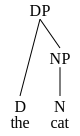

In [7]:
from nltk import Tree
svgling.draw_tree(Tree('DP', ['D\nthe', Tree('NP', ['N\ncat'])]), leaf_nodes_align=True)

The rendering options for trees rendered this way can be customized via `svgling.core.default_options`. This object is created as a default `svgling.core.TreeOptions()`, so accepts all the options documented in this manual.

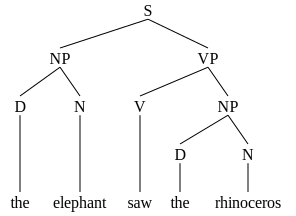

In [8]:
svgling.core.default_options.leaf_nodes_align = True
t3

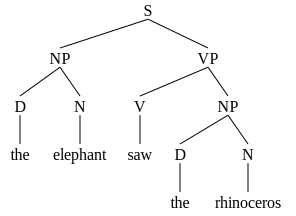

In [9]:
svgling.core.reset_defaults()
t3

The `svgling.figure` utility classes documented in [5. Hybrid HTML/SVG diagrams](#5.-Hybrid-HTML%2FSVG-diagrams) support nltk `Tree`s directly, and supports mixing of these objects and `svgling` renderable objects:

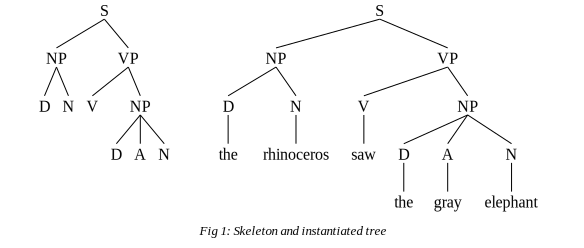

In [10]:
import svgling.figure
svgling.figure.Caption(svgling.figure.SideBySide(svgling.draw_tree(t0), t1, padding=32),
                       "Fig 1: Skeleton and instantiated tree")

## 2. Layout and display options

The customizable `TreeOptions` parameters are described in the rest of this section.

### Layout overview

**Vertical layout**: A node at depth $n$ (where the root node of the tree is depth $0$) is positioned vertically in a line with all other nodes of depth $n$. Exception (see below for examples): if `leaf_nodes_align` is set to true, any leaf nodes are aligned with the lowest level of the tree, rather than depth they would otherwise be at. Within a row, vertical space is allowed for the tallest node at that depth; positioning of shorter nodes at that depth is configurable. Vertical spacing is calculated/generated in *em*s.

**Horizontal layout**: The horizontal position of daughter nodes relative to a parent is determined by a (configurable) algorithm, usually based on some measure of the size of the daughter nodes. By default, this algorithm estimates the max text width taken up by the parent node label or the width of daughter nodes (and their daughters, etc). See below for examples of other options. No node will be positioned vertically below a node that does not dominate it. There is also a configurable padding parameter. Horizontal spacing is calculated initially in estimated *em*s, but (canvas width aside) is converted to percentages for svg layout. Because `svgling` does not do multi-pass rendering, it uses heuristics for glyph width rather than accurately calculating glyph width. (To do this, you'd basically need to render to a device, and see what happens.)

**Canvas layout**: The canvas width is estimated from node text width + padding. The canvas height is determined by the tree depth, level heights, with an extra 1em at the bottom of the canvas for descenders from leaf node glyphs.

### Debug and compatibility options

**`debug`**: When this option is set to `True`, the rendered will show a `1em` grid, as well as a red box for every subtree. This can be useful if something isn't doing what you expect. Several of the documentation examples below use this to illustrate various spacing options.

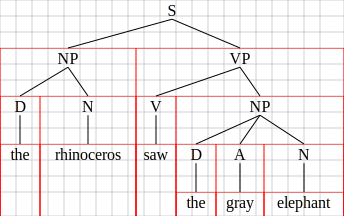

In [11]:
svgling.draw_tree(t1, debug=True)

**`relative_units`**: When this option is set to `False`, do not use relative units in the generated svg (e.g. no `em`s). This will instead use `px` values generated from the local font options. This is not guaranteed to work in general, but it should at least work with standard cases where there is no complicated font manipulation. This option is designed for compatibility with Inkscape.

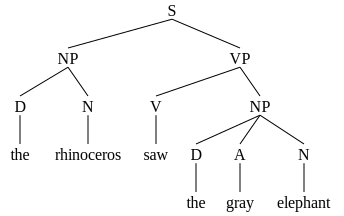

In [12]:
svgling.draw_tree(t1, relative_units=False)

### Overall layout options

The following are `TreeOptions` parameters that affect layout.

**`horiz_spacing`**: This parameter determines how daughter nodes are spaced horizontally relative to the parent. Possible values are `svgling.core.HorizSpacing.TEXT` (default; space proportionally based on estimated text width), `svgling.core.HorizSpacing.EVEN` (space evenly based on number of immediate daughters), and `svgling.core.HorizSpacing.NODES` (space proportionally to the number of leaf nodes in the subtrees).

Usually `TEXT` looks best, but the other two may be preferable for abstract trees where label widths are all similar. Without manual adjustment, the two other options will deal poorly with long labels.

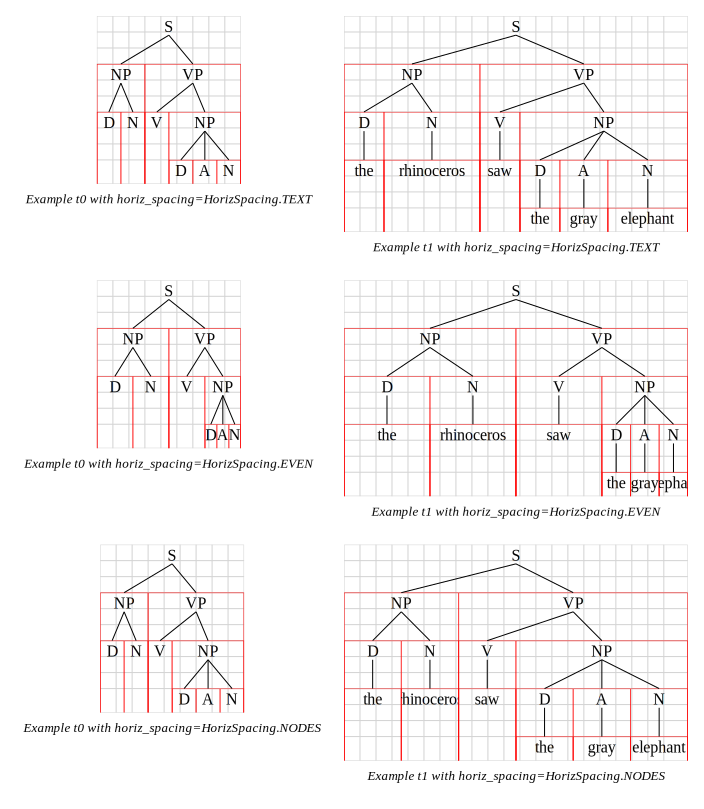

In [13]:
examples = list()
for opt in svgling.core.HorizSpacing:
    row = list()
    for t in range(len(demo_trees)):
        # debug mode on so that the exact rendering differences are very obvious
        row.append(Caption(svgling.draw_tree(demo_trees[t], horiz_spacing=opt, debug=True), "Example t%d with horiz_spacing=%s" % (t, str(opt))))
    examples.append(SideBySide(*row))

RowByRow(*examples)

**`average_glyph_width`**: A heuristic factor used to calculate text widths; basically, a divisor in *em*s. Defaults to `2.0`. Does not generally need to be adjusted for default settings (which try to just use Times), but may be worth adjusting for custom fonts.

**`leaf_padding`**: An amount to pad each leaf by, in glyphs. Will be divided by `average_glyph_width`. Default is 2. Negative values are possible, but will usually result in text being cut off. Leaf padding is applied as a constant to the overall canvas size regardless of the value of `horiz_spacing` (i.e. the canvas size is always determined by the sum of node widths plus leaf padding at every widest subtree), so will impact spacing to some degree for any setting of this option, but is only applied directly to each leaf for `HorizSpacing.TEXT`.

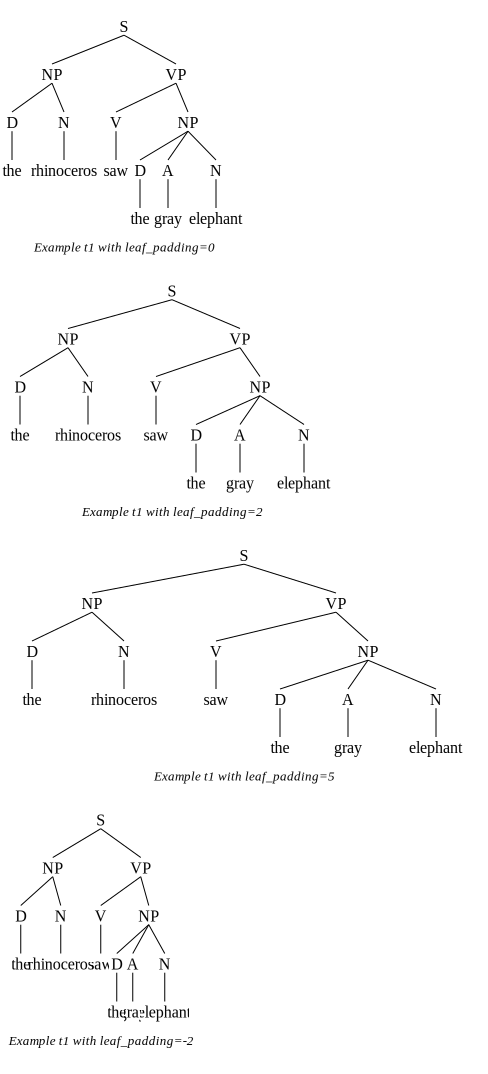

In [14]:
examples = list()
for i in (0, 2, 5, -2):
    examples.append(Caption(svgling.draw_tree(t1, leaf_padding=i), "Example t1 with leaf_padding=%g" % i))
RowByRow(*examples)

**`vert_align`**: How row alignment when there are multi-line labels should be calculated. If all labels in a row have the same height, this has no impact, but if there are differences, it controls the position of the shorter node labels vertically. Default is centered. For empty labels, this affects the position of the line join. The values `TOP`, `CENTER`, and `BOTTOM` are self-explanatory. `svgling.VertAlign.EVEN` causes all nodes to be treated as the same height (relative to their row) regardless of text contents, even empty nodes.

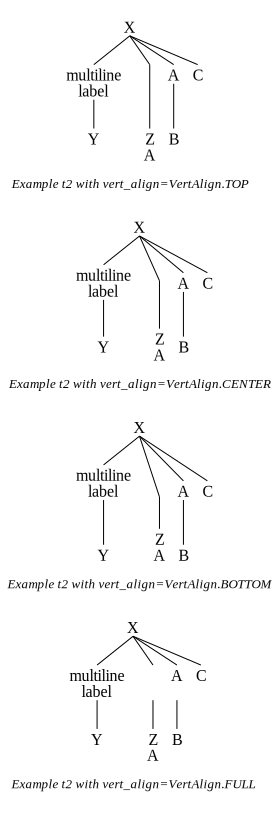

In [15]:
t2 = ("X", ("multiline\nlabel", "Y"), ("", "Z\nA"), ("A", "B"), "C")

examples = list()
for opt in svgling.core.VertAlign:
    examples.append(Caption(svgling.draw_tree(t2, vert_align=opt), "Example t2 with vert_align=%s" % str(opt)))

RowByRow(*examples)

**`distance_to_daughter`**: The distance between rows in *em*s -- that is, distance from the bottom of one row to the top of another. Values less than about 0.5 are not recommended and will usually result in rendering oddities. Note that line starts are 0.2*em*s below a node label, so 0.2 will give completely horizontal lines (not 0.0).

Default is 2.

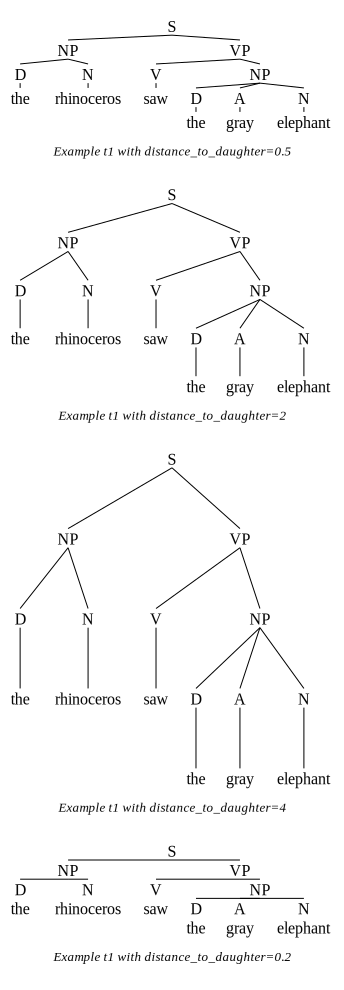

In [16]:
examples = list()
for i in (0.5, 2, 4, 0.2):
    examples.append(Caption(svgling.draw_tree(t1, distance_to_daughter=i), "Example t1 with distance_to_daughter=%g" % i))
RowByRow(*examples)

### Line and node positioning options

**`leaf_nodes_align`**: if true, will align all leaf nodes with the lowest depth leaf nodes in the tree.

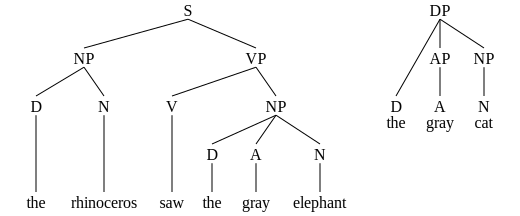

In [17]:
SideBySide(svgling.draw_tree(t1, leaf_nodes_align=True), svgling.draw_tree("DP", "D\nthe", ("AP", "A\ngray"), ("NP", "N\ncat"), leaf_nodes_align=True))

**`descend_direct`**: When an edge skips levels (currently only possible for leaf nodes, when `leaf_nodes_align=True`), should the line go directly from the parent to the daughter? If `False`, the line will go to the position that the daughter would have been at as if there is an empty node there, and descend vertically. This can be useful for very deep trees where a `True` value results in overlapping, and also just look better. However, it doesn't allow distinguishing empty nodes visually in the tree. As with empty nodes, the positioning of the line join is affected by `vert_align`. Defaults to `True`.

The following example shows a tree that renders quite badly without this option set to `True`, because of the asymmetry between leaf node widths.

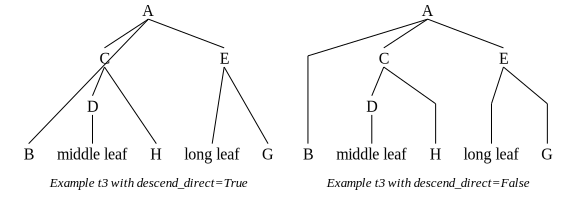

In [18]:
t3 = ("A", "B", ("C", ("D", "middle leaf"), "H"), ("E", "long leaf", "G"))
examples = list()
for opt in (True, False):
    examples.append(Caption(svgling.draw_tree(t3, leaf_nodes_align=True, descend_direct=opt), "Example t3 with descend_direct=%s" % str(opt)))
SideBySide(*examples)

### Edge styles

Custom styles can be applied to specific edges. The main application for this is drawing so-called "triangles of laziness", but it does also allow you to change the color of particular edges and other related things. There is currently no way to change the edge styles for a tree as a whole (I'll implement such a thing if there's demand for it). Be aware that non-direct descents are implemented as an edge style, so if you apply a style to a leaf node with `leaf_nodes_align=True`, then it can override the indirect descent style; use the `IndirectDescent` class to avoid this.

There are three classes that encapsulate edge styles:
* `svgling.core.EdgeStyle` is the default edge style. It allows two svg parameters: `stroke` and `stroke_width`.
* `svgling.core.IndirectDescent` implements indirect descents for nodes that skip levels. It inherits the svg parameters of `EdgeStyle`.
* `svgling.core.TriangleEdge` draws a triangle with points at the center of the parent, and the left and right bounds of the daughter text. (Note that, as usual, text width is calculated heuristically.) This class also inherits the svg parameters of `EdgeStyle`.

To set an edge style, call `set_edge_style` on the layout object with a path and one of the above objects.

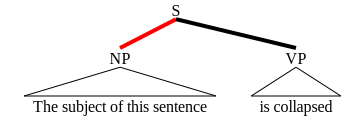

In [19]:
t5 = ("S", ("NP", "The subject of this sentence"), ("VP", "is collapsed"))
out = svgling.draw_tree(t5)
out.set_edge_style((0,0), svgling.core.TriangleEdge())
out.set_edge_style((1,0), svgling.core.TriangleEdge())
# now for some gratuitous formatting
out.set_edge_style((0,), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out.set_edge_style((1,), svgling.core.EdgeStyle(stroke_width=4))
out

### Text options

**`font_style`**: a css-formatted string that will be used to style text in the tree. Since this is css, you can put all sorts of stuff in it, but I recommend at least including `font-family`, `font-weight`, and `font-style`, because without these font rendering may be inconsistent depending on where the svg is embedded (for example showing as serif in some settings, sans-serif in others). If you are sharing your svg with others, I recommend sticking to web-safe fonts, with fallbacks. The default values is: `"font-family: times, serif; font-weight:normal; font-style: normal;"`. You cannot set font size this way.

A convenience function, `svgling.core.cssfont` takes a family and an optional named `weight` and `style` parameter and produces these strings. In addition, `svgling.core.SERIF` (the default), `svgling.core.SANS`, and `svgling.core.MONO` provide some useful presets.

**`font_size`**: a numeric value, to be interpreted in user units, for the font size. At the default sizing, `1` user unit corresponds to `1px`; SVG diagrams may be resized arbitrarily so changing the font size does not in general guarantee a bigger diagram, but it usually does. The default is `16` (which corresponds to `12pt` at the default scaling).

**`text_color`**: change the color of text in a tree. This option takes css color values. See [css documentation](https://developer.mozilla.org/en-US/docs/Web/CSS/color_value) for more on what the valid options are.

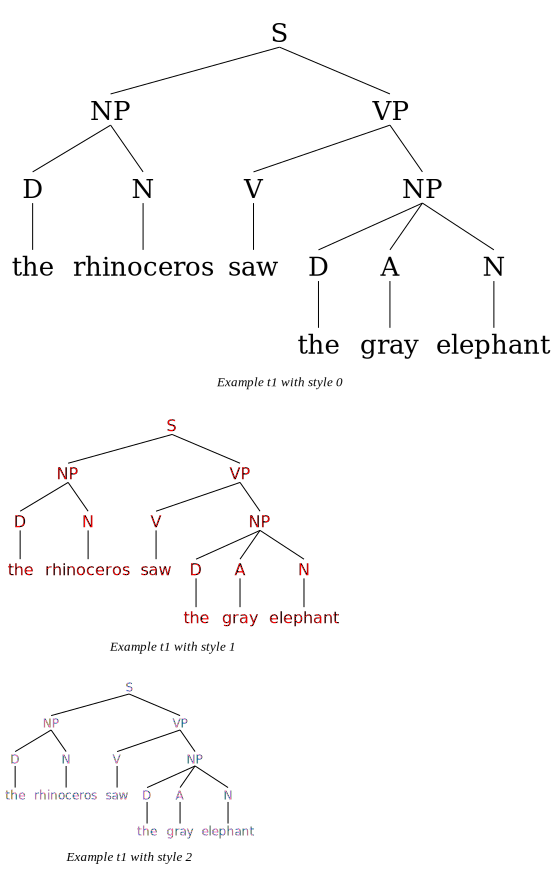

In [20]:
t1 = ("S", ("NP", ("D", "the"), ("N", "rhinoceros")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("A", "gray"), ("N", "elephant"))))
styles = (("font-family: georgia, times, serif; font-weight:normal; font-style: normal;", 26, "black"),
          ("font-family: sans-serif; font-weight:normal; font-style: normal;", 16, "red"),
          (svgling.core.cssfont("impact, times, serif", style="italic"), 12, "#FF69B4"))

examples = list()
for i in range(len(styles)):
    examples.append(Caption(svgling.draw_tree(t1, font_style=styles[i][0], font_size=styles[i][1], text_color=styles[i][2]),
                            "Example t1 with style %d" % i))
RowByRow(*examples)

### Per-node styling

A limited amount of per-node styling is possible, via the functions `set_subtree_style`, `set_node_style`, and `set_leaf_style` on an existing tree. The first two of these take a tree path and some options, and the third just takes options. These currently allow changing only the font size, style, and color, and turning on debug mode for part of the tree.

Caveats:
* The tree layout is still primarily determined by the global font size. In particular, the `distance_to_daughter` option is always interpreted relative to that font size. So if you are changing many nodes, it can make sense to adjust the global tree font size as well.
* Adding per-node styling will reset any existing tree annotations, so you will need to apply annotation calls after node styling calls.

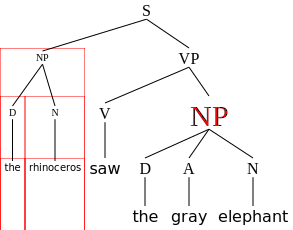

In [21]:
out = svgling.draw_tree(t1)
out.set_leaf_style(font_style = svgling.core.cssfont("impact, times, serif", style="italic"))
out.set_node_style((1,1), font_size=30, text_color="red")
out.set_subtree_style((0,), font_size=10, debug=True)
out

## 3. Tree annotations

The `draw_tree` function returns a `TreeLayout` object which can be further manipulated by adding what are called annotations. These are extra graphics that overlay on the tree, and typically interact with the tree's structure. These annotations make heavy use of **tree paths**, discussed in section 1.

### Annotating constituents

If you want to highlight a specific constituent, you can draw a box around it, and/or underline it.

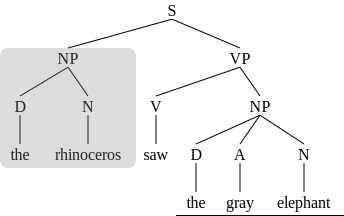

In [22]:
out = svgling.draw_tree(t1)
out.box_constituent((0,))
out.underline_constituent((1,1))
out

Both of these functions accept a number of extra svg arguments determining the details of the annotation. For `box_constituent`, you can pass `stroke`, `stroke_width`, `fill`, `fill_opacity`, and `rounding`. For `underline_constituent` you can pass `stroke`, `stroke_width`, and `stroke_opacity`. As can be seen above, boxes default to light non-opaque gray with rounded edges, and no stroke.

### Movement arrows

Movement arrows can be drawn between arbitrary constituents; `svgling` will attempt to keep them from overlapping with each other or with the tree. The arrow always starts below the center of the first constituent, descends, moves horizontally, and attaches vertically to the center of the second constituent. It can be convenient to combine arrows with some kind of constituent-grouping annotation, for complex constituents. The following example illustrates movement arrows in a typical case of Quantifier Raising.

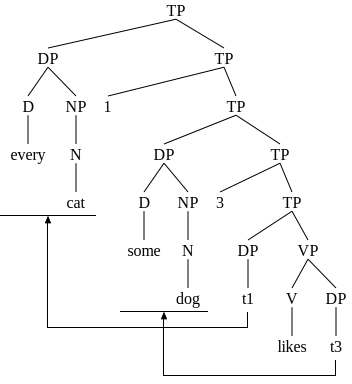

In [23]:
t2 = ("TP", ("DP", ("D", "every"), ("NP", ("N", "cat"))),
           ("TP", "1", ("TP", ("DP", ("D", "some"), ("NP", ("N", "dog"))),
                     ("TP", "3", ("TP", ("DP", "t1"), ("VP", ("V", "likes"), ("DP", "t3")))))))
out = svgling.draw_tree(t2)
out.movement_arrow((1,1,1,1,0), (0,))
out.underline_constituent((0,))
out.movement_arrow((1,1,1,1,1,1), (1,1,0), stroke_width=1, stroke="black")
out.underline_constituent((1,1,0))
out

## 4. Complex figures

As several of the above examples illustrate, `svgling.figure` provides facilities for generating more complex figures out of svg drawings. These classes are still rather basic, and they don't do well for really arbitrary figures, but they do well enough for combining `svgling` trees together. In principle, they work on any object that implements the following functions:

 * `get_svg()`: return an `svgwrite` object.
 * `height()`: get the intended diagram height *in px*.
 * `width()`: get the intended diagram width *in px*.

All the classes described here implement this interface, and so may be combined. See the above text for examples of all three of these classes. These figure classes all use a viewbox, so the sub-diagram's reported dimensions are used in user units, and the complex figure reports its own height/width in `px`.

If an object does not support `get_svg()`, the `svgling.caption` objects will attempt to convert it to a tree via `svgling.draw_tree`. The primary use case for this is so that `nltk` objects can be easily put in figures. (A surprising number of text-like objects also do work this way.)

**`Caption`**: This places a text caption below an svg drawing. Construct with `Caption(fig, text)`.

**`SideBySide`**: This places a list of svg drawings in a row. Construct with `SideBySide(fig1, fig2, ..., fign, padding=x)`, where `padding` gives a padding in pixels to be applied between subfigures and in the left and right margin.

**`RowByRow`**: This places a list of svg drawings in a column. Construct with `RowByRow(fig1, fig2, ..., fign, padding=x)`, where `padding` gives a padding pixels to be applied between subfigures and in the top and bottom margin. By default, if the rows are themselves `SideBySide` objects, this will adjust the widths so that individual diagrams form a grid. To disable this, pass `gridify=False` to the constructor.

**`svgling.semantics.DoubleBrackets`**: There is so far one linguistics-specific complex figure class, which produces semantics-style double brackets around a tree. Simply call this with a tree layout object to get decent results. You can also adjust `padding` (including negatively) and `bracket_width`. Here's an example from Heim and Kratzer 1998, ch. 2:

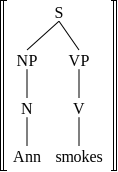

In [24]:
import svgling.semantics
svgling.semantics.DoubleBrackets(svgling.draw_tree("S", ("NP", ("N", "Ann")), ("VP", ("V", "smokes"))))

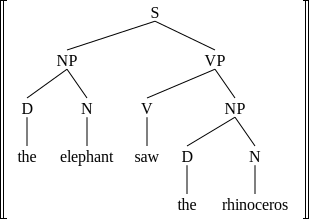

In [25]:
import nltk
# illustrate direct use of an nltk.Tree object
svgling.semantics.DoubleBrackets(nltk.Tree.fromstring("(S (NP (D the) (N elephant)) (VP (V saw) (NP (D the) (N rhinoceros))))"))

## 5. Hybrid HTML/SVG diagrams

This package provides limited support for tree diagrams that mix HTML/CSS and SVG, using the former for layout and the latter for line drawing, via the `svgling.html` module. These have a number of limitations relative to pure SVG diagrams, with two main advantages: (i) the nodes can consist of arbitrary HTML/CSS, including mathjax, `xml.etree.ElementTree` objects, and more and (ii) sizing of the overall tree diagrams is fully automatic based on leaf node sizes. The limitations are detailed below, but the main one to know about is that these trees do not support branching greater than binary. As with the rest of this package, the hybrid layout techniques are single-pass and make do without any javascript. The rendering techniques require up-to-date and recent browsers; needless to say but Internet Explorer / Edge (until it has switched over to the Chromium renderer) is unlikely to work, and I have no plans to support it. At the moment, these trees are less intended for direct instantiation and more intended for programmatic use.

The module interface is similar, with `svgling.html.draw_tree` as the main interface function, and `svgling.html.DivTreeLayout` as the main class parallel to `svgling.core.TreeLayout`, and `svgling.core.TreeOptions` used to configure the tree (though see below for supported parameters). After the following examples, I will give a precise list of the limitations relative to SVG diagrams and the supported options.

First, an example of the default output for one of our standard examples:

In [26]:
svgling.html.draw_tree("S", ("NP", ("D", "the"), ("N", "elephant")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("N", "rhinoceros"))), horiz_spacing=svgling.core.HorizSpacing.TEXT)

The `HorizSpacing.EVEN` option can be used, but usually looks huge for unbalanced trees. (With comparable node padding, for this option only the spacing is identical to `svgling.core`.)

In [27]:
svgling.html.draw_tree("S", ("NP", ("D", "the"), ("N", "elephant")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("N", "rhinoceros"))), horiz_spacing=svgling.core.HorizSpacing.EVEN)

The main immediate benefit for interactive use is the availability of MathJax in nodes.  (**caveat**: latex rendering via HTML outputs will not work in Google Colab.) Don't forget to escape `\` characters (as `\\`) as needed:

In [28]:
svgling.html.draw_tree("$\\text{Saw}(\\iota x_e{:\:}\\text{Elephant}(x),\\iota x_e{:\:}\\text{Rhino}(x))$", ("$\\iota x_e{:\:}\\text{Elephant}(x)$", "$\\lambda f_{\\langle e,t \\rangle }{:\:}\\iota x_e{:\:}f(x)$", "$\\lambda x_e{:\:}\\text{Elephant}(x)$"), ("$\\lambda x_e{:\:}\\text{Saw}(x,\\iota x_e{:\:}\\text{Rhino}(x))$", "$\\lambda y_e{:\:}\\lambda x_e{:\:}\\text{Saw}(x,y)$", ("$\\iota x_e{:\:}\\text{Rhino}(x)$", "$\\lambda f_{\\langle e,t \\rangle }{:\:}\\iota x_e{:\:}f(x)$", "$\\lambda x_e{:\:}\\text{Rhino}(x)$")))

One quick way to do multiline nodes is to use MathJax to insert the linebreaks. However, note the manual spacing in the following example -- if you want to do things like automatically centering, you'll need full HTML.

In [29]:
# mathjax currently has really bizarre behavior in this example depending on the delimiter used
svgling.html.draw_tree(
    "$\\iota x_e{:\:}\\text{Elephant}(x)\\\\\\hspace{0.8cm}\\text{Type: }e$",
        "\\[\\lambda f_{\\langle e,t \\rangle }{:\:}\\iota x_e{:\:}f(x)\\\\\\hspace{0.2cm}\\text{Type: }\\langle \\langle e,t\\rangle ,e\\rangle\\]",
        "\\[\\lambda x_e{:\:}\\text{Elephant}(x)\\\\\\hspace{0.2cm}\\text{Type: }\\langle e,t\\rangle\\]")


Because of the spacing issue, and the fact that multi-line MathJax rendering currently has varied results depending on the renderer and the math mode delimiter, there is a convenience function `multiline_text` that uses HTML to do the linebreaks. (See the gallery for the full example rendered using this technique.)

In [30]:
import svgling.html
from svgling.html import multiline_text as ml
svgling.html.draw_tree(
    ml("$\\iota x_e{:\:}\\text{Elephant}(x)$", "$\\text{Type: }e$"),
        ml("$\\lambda f_{\\langle e,t \\rangle }{:\:}\\iota x_e{:\:}f(x)$", "$\\text{Type: }\\langle \\langle e,t\\rangle ,e\\rangle$"),
        ml("$\\lambda x_e{:\:}\\text{Elephant}(x)$", "$\\text{Type: }\\langle e,t\\rangle$"))


A more advanced technique to accomplish linebreaks, as well as many other things, would be to use an HTML node directly. More generally, there are several kinds of objects that can be used as nodes in `svgling.html`, which is much more flexible than `svgling.core` in this respect (see `svgling.html.to_html` for the conversion algorithm):

* a string (shown above). You can't just embed html code in a string, it will show up as escaped html. But you can use `$..$` or other delimiters to insert MathJax. (Depending on the version, `\[..\]` may be more reliable than `$..$` for embedding in html like this.)
* an `Element` object from the [`xml.etree.ElementTree` API](https://docs.python.org/3/library/xml.etree.elementtree.html). I will not document this in detail here, and this is intended for programmatic use. (In fact, this is how the `multiline_text` function above works -- this function returns `Element` objects.)
* an object that implements `_repr_latex_()` from the IPython API.
* an object that implements `_repr_html_()` from the IPython API. The string outputted by this function *must* be parseable by `xml.etree.ElementTree.fromstring`, and if it isn't the tree will fail to display. (One common source of this issue would be using `&nbsp;` in the output, as unfortunately this class makes it a bit tricky to parse HTML entities. A second common source is to use text that is not enclosed in some kind of tag, e.g. a `<span>`.)
* If none of the above work, the output of `repr` called on the object is used as a string.

If you want to use HTML text interactively, one quick way to get an object that can be used as a node is to use `IPython.display.HTML` to turn an HTML string into an object that implements `_repr_html_()`.

You can mix all of these node types in a single tree, as in the following example:

In [31]:
from IPython.display import HTML
# mathjax notes: using $ as the delimiter here in the B node in recent versions
# forces mathjax to use a "fullwidth" class that renders poorly. Also, for some
# reason the \[ delimiters force a linebreak after the equation. 
svgling.html.draw_tree("X",
    (HTML("<span>Y<br />Y2</span>"), 'Z', '$Z\'$'),
    ('A', HTML("<div style=\"text-align:center;border:1px dashed;background-color:lightgray;\"><span>B<br />\\[\\text{some}^{\\text{mathjax}^\\text{!!!}}\\]B3</span></div>")))


As some of the discussion above has implied, the primary target for `svgling.html` is not interactive tree diagram construction per se, but rather programmatic use in packages that will generate complex HTML from structured python objects, for example the [Lambda Notebook](https://github.com/rawlins/lambda-notebook). (This package does not yet use `svgling.html`, but it will soon: when it does I will link to specific examples here.)

**Limitations and quirks of `svgling.html`**:

* Branching can be at most binary.
* The layout algorithms make no effort to ensure alignment along horizontal axes across subtrees, in contrast to SVG diagrams.
* Many TreeOptions settings are not supported; see below.
* Multi-line (in fact arbitrarily complex) nodes are supported, but have a somewhat more complex way of instantiating them (using HTML or MathJax).
* More generally, rendering in complex diagrams is at the mercy of mathjax's css, which can sometimes be very odd indeed. (See notes above about delimiter choice.)
* Edge styles are not supported, and neither are the per-node style calls used in `svgling.core`.
* Annotations are not supported.
* Composite diagrams involving hybrid trees are not supported.
* Rendering does not work quite right in Safari due to browser-specific quirks that I have so far not been able to work around. (Basically, trees end up wider than intended.)
* Bug, but one that is extremely hard to work around given the current rendering techniques: non-leaf nodes do not contribute correctly to the tree size calculations, resulting in extra whitespace in the left daughter branch for very wide parent nodes.

**Supported and unsupported `TreeOptions` parameters**

* `distance_to_daughter` is used.
* `font_style` and `font_size` are used and interpreted the same way. *However*, because arbitrary HTML/CSS can be provided or used, this module doesn't guarantee that these options will apply to everything in the tree; the user can override these in various ways. In particular, MathJax is pretty much certain to override the font style.
* `debug` is supported - it will draw boxes around various subtrees, though not draw the grid used for svg diagrams.
* `horiz_spacing`: only `TEXT` and `EVEN` are supported; `NODES` is not (and probably will never be). The default is `TEXT`.
* `vert_align` is ignored, and in fact since nodes are not aligned along a horizontal axis between subtrees (in contrast to SVG diagrams) this parameter doesn't make since for the hybrid tree layout algorithms.
* `leaf_padding`: currently not used; it also wouldn't make sense to interpret this in the same way, as this would be an unnecessary heuristic for hybrid diagrams. Currently an (accurate, rather than heuristic) padding of `0.75em` is used for all trees. For similar reasons, `average_glyph_width` is not used because it is unnecessary.
* `leaf_nodes_align` and `descend_direct` are not supported.

# 6. Compatibility and conversion

With default settings, the SVG files produced by `svgling` should be compatible with all major browsers
(Chrome, Firefox, Safari, Edge) on both desktop and mobile, as well as all major svg editors/viewers/converters; if you find a compatibility issue with some browser, please [report it as a bug](https://github.com/rawlins/svgling/issues). (Note: with the deprecated `relative_units=True` setting, there are known incompatibilities with certain software packages that do not correctly handle nested `svg` tags.)

## File output

To save SVG output to a file, see the [svgwrite.Drawing api](https://svgwrite.readthedocs.io/en/stable/classes/drawing.html); any object returned by `draw_tree(...).get_svg()` is `Drawing` object. For convenience, `svgling` classes also pass through `saveas`. For example:

In [32]:
# uncomment to write to `demotree.svg` with human-readable formatting
# demo_tree = ("S", ("NP", ("D", "the"), ("N", "elephant")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("N", "rhinoceros"))))
# svgling.draw_tree(demo_tree).saveas("demotree.svg", pretty=True)

(Since SVG is just text/xml, it can of course be written to a file via all sorts of other means.)

In addition, the module itself supports generating svg at the command line, if passed a valid tree description via python data structures. For example, the following command (on linux/macos) will generate the same file:

```bash
python -m svgling '("S", ("NP", ("D", "the"), ("N", "elephant")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("N", "rhinoceros"))))' > demotree.svg
```

## Format conversion

To convert generated `svg` images to other formats both raster and vector, you have many options, both interactive and not. `svgling` provides builtin support for doing this via the [`cairosvg`](https://cairosvg.org/) package if it's installed. The `svgling.utils` module provides a light wrapper for `cairosvg`'s `svg2png`, `svg2pdf`, and `svg2ps` that take any IPython svg-rendering object as their first argument, and otherwise have the same api as the corresponding `cairosvg` functions.

* If `write_to` is set, they will write to a file, otherwise they return a byte object. For `svg2png`, the returned object is conveniently compatible with `IPython.display.Image`, as in the example below.
* They take various parameters including `scale`, `height`, `width`, `dpi`, etc.
* See the [cairosvg documentation](https://cairosvg.org/documentation/) for details on other named parameters that these functions accept.

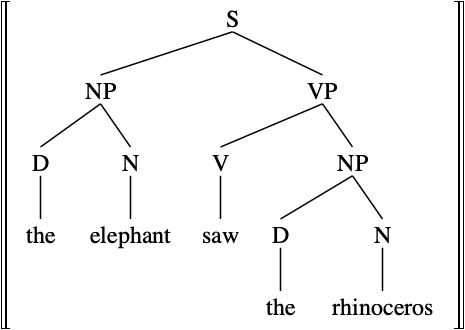

In [33]:
import svgling.utils, svgling.semantics, nltk
from IPython.display import Image
t = svgling.semantics.DoubleBrackets(nltk.Tree.fromstring("(S (NP (D the) (N elephant)) (VP (V saw) (NP (D the) (N rhinoceros))))"))
Image(svgling.utils.svg2png(t, scale=1.5))
# or, to generate a file, uncomment:
# svgling.utils.svg2png(t, scale=2, write_to="elephant.png")